## Remapping population density 
The aim of this little script is to remap all of the population density (from 1850 to 2014) and condense down into one file

In [105]:
%load_ext autoreload
%autoreload

import sys
sys.path.append('../')

import warnings
warnings.filterwarnings('ignore')

import os
from   io     import StringIO
import numpy  as np
import pandas as pd
import csv

import iris
import iris.plot as iplt
from iris.experimental.equalise_cubes import equalise_attributes
import matplotlib.pyplot as plt
import numpy.ma as ma
%matplotlib inline
import cartopy.crs as ccrs
from   libs.plot_maps    import *
from netCDF4 import Dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [53]:
dir = '../data/pop_dens/'

year = range(1850,2015)
files = []

for y in year:
    files.append('PD_HYDEv3.2_' + str(y) + '.nc')
    

### Load in data
Merge all .nc files together. None of the files specify a time stamp, so I've removed the time coordinate, and added another one in which tells iris the year. It can then concatenate (still keeps the same number of dimensions) into one cube

In [106]:
dir = '../data/pop_dens/'

year = range(1850,2015)
files = []
aList = []
i = 0

# Load data and create a cube list (very inefficiently)
for y in year:
    files.append('PD_HYDEv3.2_' + str(y) + '.nc')
    dat = iris.load_cube(dir + files[i])
    
    # Dim coord
    coord = iris.coords.DimCoord(y, 'time')
    dat.remove_coord('time')
    dat.add_dim_coord(coord,0)
    
    # Aux coord
#     coord = iris.coords.AuxCoord(y, 'year')
#     dat.add_aux_coord(coord)
    
    aList.append(dat)
    i += 1

In [100]:
#print(cube_list[0])
print(dat.coord('time'))

DimCoord(array([2014]), standard_name='time', units=Unit('1'))


In [102]:
# Merge cube list together 
cube_list = iris.cube.CubeList(aList)
# cubes = cube_list.merge_cube()
cubes = cube_list.concatenate_cube()
# test = cubes[0:2]
print(cubes)

pop_den / (1)                       (time: 165; latitude: 144; longitude: 192)
     Dimension coordinates:
          time                           x              -               -
          latitude                       -              x               -
          longitude                      -              -               x
     Attributes:
          CDI: Climate Data Interface version 1.7.0 (http://mpimet.mpg.de/cdi)
          CDO: Climate Data Operators version 1.7.0 (http://mpimet.mpg.de/cdo)
          Conventions: CF-1.5
          STASH: m01s00i627
          data description: HYDE3.2 regridded for JULES input.
          data reference: Klein Goldewijk, K. , A. Beusen, M. de Vos and G. van Drecht (2011). The...
          data units: (inhabitants/km2)
          data url: ftp://ftp.pbl.nl/hyde/hyde32/2017_beta_release/001/zip/
          data variable: population density
          file: make_popdens.r
          history: Tue Oct 16 08:56:51 2018: cdo chname,m01s00i627,pop_den out.nc 

Load the mask

In [107]:
mask_dir = '../data/n96_masked_data/'
file = 'no_t_n96_mask.nc'

mask = iris.load_cube(mask_dir + file)

Plot data to check if it's loaded in correctly

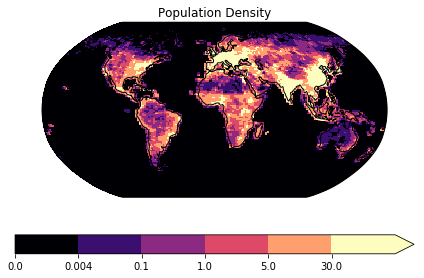

In [108]:
dat = cubes.collapsed('time', iris.analysis.MEAN)
dat.long_name = 'Population Density'
plot_lonely_cube(dat, cmap = 'magma', levels = None)

## Regrid
Using the mask n96e from 'regrid_nc' notebook, we're going to regrid the data. The main difference is the labelling of the lat and lon - both the original and the masked grid have the same number of coordinates

In [109]:
m_cube = cubes.regrid(mask, iris.analysis.Linear())

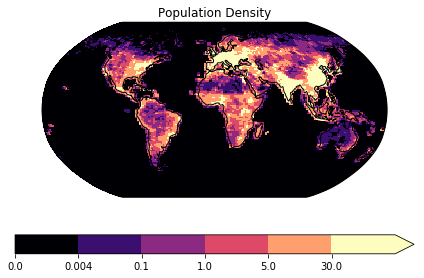

In [110]:
out = '../data/n96_masked_data/outputs/' + str(years[0]) + '-' + str(years[len(years)-1]) + '.nc'
iris.save(m_cube, out)